## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
import numpy as np
import torch

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


class RNN(nn.Module):
    def __init__(self, num_classes, emb_size, hidden_size):
        super().__init__()
        self.num_classes = num_classes
        self.one_hot_to_emb = nn.Linear(num_classes, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, initial_state=None):
        x_emb = self.one_hot_to_emb(F.one_hot(x, self.num_classes).float())
        h_seq, hid_state = self.rnn(x_emb, initial_state)
        next_logit = self.hid_to_logits(h_seq)
        return next_logit, hid_state

In [8]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, sample_length, token_to_idx, idx_to_token):
        self.data = data
        self.sample_length = sample_length
        self.token_to_idx = token_to_idx
        self.idx_to_token = idx_to_token
        
    def __len__(self):
        return len(self.data) - self.sample_length
    
    def __getitem__(self, index):
        text = self.data[index:index + self.sample_length]
        tokenized_seq = np.array([token_to_idx[token] for token in text])
        X = tokenized_seq[:-1]
        y = tokenized_seq[1:]
        return X, y

In [9]:
USE_CUDA = torch.cuda.is_available()

SAMPLE_LENGTH = 150
BATCH_SIZE = 1024
NUM_WORKERS = 24

NUM_CLASSES = len(tokens)
EMB_SIZE = 64
HIDDEN_SIZE = 128

LR = 1e-3
EPOCHS = 40

device = torch.device('cuda:0') if USE_CUDA else torch.device('cpu')

train_dataset = ShakespeareDataset(text, SAMPLE_LENGTH, token_to_idx, idx_to_token)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True
)

rnn_model = RNN(NUM_CLASSES, EMB_SIZE, HIDDEN_SIZE).to(device)
optimizer = optim.Adam(rnn_model.parameters(), LR)
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, criterion, epochs):
    t_epochs = tqdm(range(epochs))
    avg_train_losses = []

    for epoch in t_epochs:
        avg_train_loss = 0

        t_train_loader = tqdm(
            train_loader,
            total=len(train_loader),
            leave=False
        )

        for X_batch, y_batch in t_train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred, _ = model(X_batch)

            loss = criterion(y_pred.view(-1, model.num_classes), y_batch.view(-1))
            train_loss = loss.item()

            t_train_loader.set_postfix(train_loss=train_loss)
            avg_train_loss += train_loss / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        t_epochs.set_postfix(avg_train_loss=avg_train_loss)
        avg_train_losses.append(avg_train_loss)   
    return avg_train_losses

avg_train_losses = train(rnn_model, optimizer, criterion, EPOCHS)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

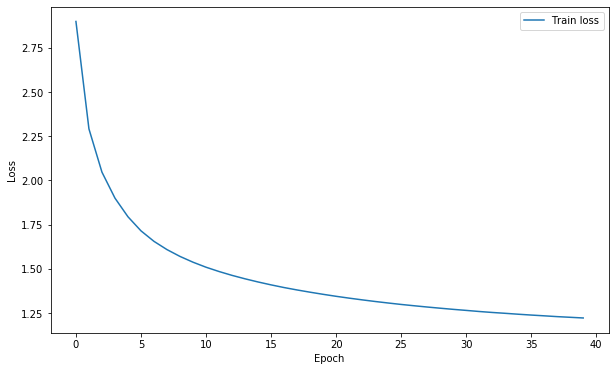

In [10]:
import matplotlib.pyplot as plt

def plot_train_loss(avg_train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_losses, label='Train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend();

plot_train_loss(avg_train_losses)

In [11]:
def generate_text(model, hid_state=None, seed_phrase='  xxvi', length=100, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = model(x_sequence[:, :, i], hid_state)

    #start generating
    for _ in range(length - len(seed_phrase)):
        out, hid_state = model(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [12]:
# An example of generated text
print(
    generate_text(
        rnn_model.cpu(),
        seed_phrase='  xxvi',
        length=1000,
        temperature=0.7
    )
)

  xxviii

  whore all the false old,
  or alones not with inle well of oree
  delain, and to in my head, be natere
  sweet sake thy most,
  since my bed she well, so framil'd of my side;
    since to be that with thereon my dear death my most oterns,
  and happy i bring in thy most praise;
  when i will then than such slows and thy self tome see,
  my love thou thy shade in my bid the things amoverse,
  the baiv'nes time,
  in it is it the ourstant can of thy seem counting alone,
  but then all the rues with thee with both and it mine eye
  i am thou tens if that this shorldst thou scated and shall sight of thy sweat the heart;
    which to hear time all self-doys.
    their brind prive than remays
  thine upon did it life,
  what i net ornelt sootces of this part from in his complext;
  nor him cold, and store thou ulless to make the grosest wanting me heart woe,
  and the beauty invinks im that hell verse verie all were,
  of love is for agess,
  and i true more i see,
  since taskin

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_classes, emb_size, hidden_size):
        super().__init__()
        self.num_classes = num_classes
        self.one_hot_to_emb = nn.Linear(num_classes, emb_size)
        self.rnn = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, initial_state=None):
        x_emb = self.one_hot_to_emb(F.one_hot(x, self.num_classes).float())
        h_seq, hid_state = self.rnn(x_emb, initial_state)
        next_logit = self.hid_to_logits(h_seq)
        return next_logit, hid_state

In [14]:
lstm_model = LSTM(NUM_CLASSES, EMB_SIZE, HIDDEN_SIZE).to(device)
optimizer = optim.Adam(lstm_model.parameters(), LR)
criterion = nn.CrossEntropyLoss()

avg_train_losses = train(lstm_model, optimizer, criterion, EPOCHS)

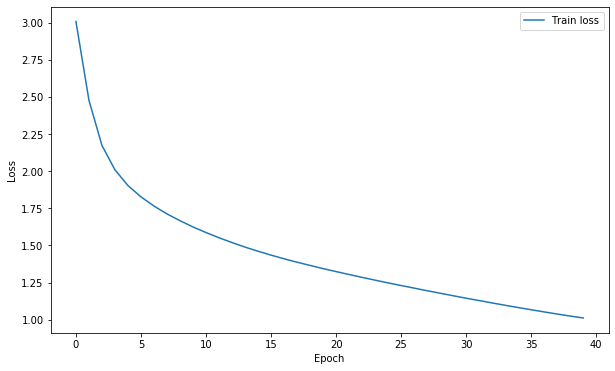

In [15]:
plot_train_loss(avg_train_losses)

LSTM model has less train loss (1.01) than vanilla RNN (train loss = 1.22).

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [16]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(
        f'temperature = {temperature} \n\n',
        generate_text(
            lstm_model.cpu(),
            seed_phrase=' xxvi',
            length=400,
            temperature=temperature
        ),
        '\n  #############################################\n'
    )

temperature = 0.1 

  xxvii

  that thou art thou thy shadow i say i dread
  thy sweet false worth the loss in the sunfers
  the beauty should be beauty should dear,
  that the world an ever the world with all thee,
  and more that love to the world so should to my sigh,
  when i have seem be the tears to the sun thee.

  xiv

  no must thou dear love the world so should to my sigh,
  when i have seeming compare to th 
  #############################################

temperature = 0.2 

  xxviii

  how can yourse, nor the world will be thine his breast.

  cxxvi

  let me not constancy and heart that well,
  whom the preseage all dear love to show,
  and therefore mayst be forsumed to the sweet,
  and in the world comment of the sad make thee,
  and sweet self the strongest a semplace should to me,
  and though the subject thoughts and the subject lends.
  thou sweet show the day  
  #############################################

temperature = 0.5 

  xxvi

    so shall other state the

Text generated with a higher temperature has less meaning, but more various output.

Text generation with lower temperature sometimes gets stuck with repeating of certain words.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [17]:
MODEL_SAVE_PATH = 'lstm_model.pth'

torch.save(lstm_model.state_dict(), MODEL_SAVE_PATH)

lstm_model = LSTM(NUM_CLASSES, EMB_SIZE, HIDDEN_SIZE)
lstm_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(
    generate_text(
        lstm_model,
        seed_phrase='  xxvi',
        length=1000,
        temperature=1.0
    )
)

  xxvii

  even i could dyyme thy from the staintage;
  lone of harre, save pleasure excenden's hard,
  dost conce and daring day u soreast;
    and a never's your lasge unkne sured toum thy versail.

  lxxxiiii

  man that you would thought, then tence oned age;
  nor cure then powers in guss, yet winter'd worss.
  to beht, why thy good wit subjectull-ten;
  then shall best into hatt myself do soy
  distains thy lovers seeming store thee,
  and found penitest outward shalt strond.

  low
  thou seals have steefurest thou store in howory.

  xix

  me whose shall know with that take may skill!
    wheremost i forgeceint of that wet him.
    it heart tap not gravesh with-phand so rettly hall fought
    and dead beauty thou genart! treasure times to his sigh
  how to fast, or caultse thee no preasont well
  though tappob'd for my nows wond a know;
  and hack one pen'd shall opprofied may
  if his unfath'd firsher in thy goss,
  which from masials show two live me griend.

  xciv

  priek

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)